In [1]:
import torch
from torch import nn
import pandas as pd
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm
import math
from hilbertcurve.hilbertcurve import HilbertCurve
from math import sqrt
from torchvision import datasets, transforms

In [2]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 20
PATIANCE = 10
LEARNING_RATE = 1e-3
NUM_CLASSES = 10
PATCH_SIZE = 7
IMAGE_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 7
DROPUT = 0.001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION = "gelu"
NUM_ENCODERS = 4
EMBEDING_DIMENTION = (PATCH_SIZE**2) * IN_CHANNELS 
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2 

print(NUM_PATCHES)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Cuda Specific 
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Apple Metal Specific 
torch.mps.manual_seed(RANDOM_SEED)

16


In [3]:
if torch.backends.mps.is_available(): 
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

mps


In [4]:
def HilbertIndices(n):
    """
    Generate Hilbert indices for a grid approximating a square layout of patches.

    Args:
    n (int): Total number of patches.

    Returns:
    np.array: Indices sorted according to Hilbert curve distances.
    """
    # Determine the order of the Hilbert curve based on the number of patches
    order = int(np.ceil(np.log2(np.sqrt(n))))
    
    # Initialize Hilbert curve with 2 dimensions and determined order
    hilbert_curve = HilbertCurve(p=2, n=order)
    points = []

    # Determine the maximum x and y values based on the number of patches
    side_length = int(np.ceil(np.sqrt(n)))

    # Collect all points whose Hilbert distances need to be calculated
    for i in range(n):
        x = i // side_length
        y = i % side_length
        points.append([x, y])

    # Calculate the Hilbert distances for all points
    distances = hilbert_curve.distances_from_points(points)

    # Return the indices sorted by their Hilbert distances
    return np.array(distances).argsort()

In [5]:
class PositionalEmbeddingStrategy(nn.Module):
    def forward(self, x):
        raise NotImplementedError("Each Embedding Strategy must implement the forward method.")

In [6]:
class PatchEmbeddingLearnedPositionalEmbedding(PositionalEmbeddingStrategy):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size
            ),
            nn.Flatten(2)
        )

        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches + 1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x

In [7]:
class PatchEmbeddingNoPositionalEmbedding(PositionalEmbeddingStrategy):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size
            ),
            nn.Flatten(2)
        )

        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat((cls_token, x), dim=1)
        x = self.dropout(x)
        return x

In [8]:
class PatchEmbeddingHilbertPositionalEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels, order):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size
            ),
            nn.Flatten(2)
        )

        # Hilbert curve positional embeddings
        hilbert_indices = HilbertIndices(num_patches)
        position = torch.arange(0, num_patches, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, 2 * embed_dim, 2).float() * (-np.log(10000.0) / (2 * embed_dim)))
        
        # print("Embed dim", embed_dim)

        # Adjust the shape of pe to match the size of position * div_term

        # print("Number of patches", num_patches)
        pe = torch.zeros(num_patches, embed_dim) 
        #assert pe.size() == torch.Size([16, 49]), "Size of pe tensor does not match expected size [16, 49]"

        

        # print("Size of hilbert indicies: ", hilbert_indices.size)
        # print("Size of pe tensor before assignment:", pe.size())
        # print("Size of position * div_term tensor:", (position * div_term).size())
        

        # Adds the sin and cos values for each alternating collumn to add positional embeddings
        pe[:, 0::2] = torch.sin(position * div_term)[:, 0::2]
        pe[:, 1::2] = torch.cos(position * div_term)[:, 1::2]
        # print("Size of pe tensor after assignment:", pe.size())

        assert pe.size() == torch.Size([NUM_PATCHES, PATCH_SIZE**2])

        pe = pe[hilbert_indices]  # reorder according to Hilbert curve


        # Remove the cls token from positional embeddings
        self.position_embeddings = nn.Parameter(pe[:], requires_grad=False)

        # print("Size of pe tensor after assignment AAAAA:", pe.size())
        # print("Pos embed aaaaaaaa", self.position_embeddings.size())

        # Add cls token separately
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = self.patcher(x).permute(0, 2, 1)

        # print("Shape of x:", x.shape) 
        # print("Shape of x after cat:", x.shape)
        # print("Shape of position_embeddings:", self.position_embeddings.shape)
        x = x + self.position_embeddings
        x = torch.cat((cls_token, x), dim=1)
        x = self.dropout(x)
        return x

In [9]:
class Vit(nn.Module):
    def __init__(self, embedding_strategy, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embedings_block = embedding_strategy

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embedings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0 , :])
        return x

In [10]:
train_df = pd.read_csv("../fashion-mnist_train.csv")
test_df = pd.read_csv("../fashion-mnist_test.csv")

In [11]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

In [14]:
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self. indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28,28)).astype(np.uint8)  
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "label": label, "index": index}

In [15]:
class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self. indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28,28)).astype(np.uint8)  
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "label": label, "index": index}

In [16]:
class MNISTTestDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self. indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28,28)).astype(np.uint8)  
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "label": label, "index": index}

54000
------------------------------
6000
------------------------------
10000


Text(0.5, 1.0, 'Test Image')

<Figure size 640x480 with 0 Axes>

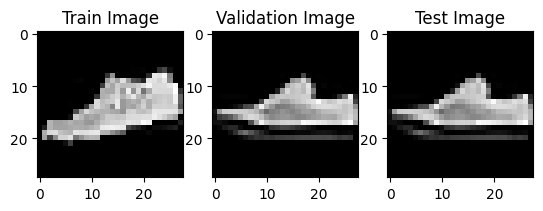

In [17]:
plt.figure()
f, axarr = plt.subplots(1, 3)

train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
print(len(train_dataset))
axarr[0].imshow(train_dataset[0]["image"].squeeze(), cmap="gray")
axarr[0].set_title("Train Image")
print("-"*30)


val_dataset = MNISTValDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
print(len(val_dataset))
axarr[1].imshow(val_dataset[0]["image"].squeeze(), cmap="gray")
axarr[1].set_title("Validation Image")
print("-"*30)


test_dataset = MNISTTestDataset(test_df.iloc[:, 1:].values.astype(np.uint8), test_df.iloc[:, 0].values, test_df.index.values)
print(len(test_dataset))
axarr[2].imshow(val_dataset[0]["image"].squeeze(), cmap="gray")
axarr[2].set_title("Test Image")

In [18]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
def training_loop(embedding_strategy, checkpoint_path):
    model = Vit(embedding_strategy, NUM_PATCHES, IMAGE_SIZE, NUM_CLASSES, PATCH_SIZE, EMBEDING_DIMENTION, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPUT, ACTIVATION, IN_CHANNELS).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

    best_val_loss = float('inf')

    epochs_no_improve = 0
    early_stop = False

    start = timeit.default_timer()

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in tqdm(range(EPOCHS), position=0, leave=True):
        model.train()
        train_labels = []
        train_preds = []
        train_running_loss = 0

        for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)

            train_labels.extend(label.cpu().detach())
            train_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_running_loss += loss.item()
        
        train_loss = train_running_loss / (idx+1)

        model.eval()
        val_labels = []
        val_preds = []
        val_running_loss = 0

        with torch.no_grad():
            for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
                img = img_label["image"].float().to(device)
                label = img_label["label"].type(torch.uint8).to(device)
                y_pred = model(img)
                y_pred_label = torch.argmax(y_pred, dim=1)

                val_labels.extend(label.cpu().detach())
                val_preds.extend(y_pred_label.cpu().detach())

                loss = criterion(y_pred, label)

                val_running_loss += loss.item()

        val_loss = val_running_loss / (idx+1)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Epoch {epoch+1}: New best model saved with val_loss: {val_loss:.4f}')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == PATIANCE:
            print("Early stopping triggered")
            early_stop = True
            break

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracy = sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels)
        val_accuracy = sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print("-"*30)
        print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
        print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
        print(f"Train Accuracy EPOCH {epoch+1}: {train_accuracy:.4f}")
        print(f"Valid Accuracy EPOCH {epoch+1}: {val_accuracy:.4f}")
        print("-"*30)

    if not early_stop:
        print("Completed all epochs without early stopping.")

    stop = timeit.default_timer()
    print(f"Training Time: {stop-start:.2f}s")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    fig.suptitle('Training and Validation Metrics')

    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Loss over epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(train_accuracies, label='Train Accuracy')
    ax2.plot(val_accuracies, label='Validation Accuracy')
    ax2.set_title('Accuracy over epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

    return model

In [20]:
def test_model(model, checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()
    test_running_loss = 0
    test_labels = []
    test_preds = []
    criterion = nn.CrossEntropyLoss()  

    with torch.no_grad(): 
        for img_label in tqdm(test_dataloader, position=0, leave=True):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)

            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)

            test_labels.extend(label.cpu().detach())
            test_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)
            test_running_loss += loss.item()

    test_loss = test_running_loss / len(test_dataloader)
    test_accuracy = sum(1 for x, y in zip(test_preds, test_labels) if x == y) / len(test_labels)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

/Users/nihat/mambaforge/envs/bachelor-project/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
  5%|▌         | 1/20 [00:18<05:49, 18.37s/it]

Epoch 1: New best model saved with val_loss: 0.8277
------------------------------
Train Loss EPOCH 1: 1.5603
Valid Loss EPOCH 1: 0.8277
Train Accuracy EPOCH 1: 0.4060
Valid Accuracy EPOCH 1: 0.6600
------------------------------


 10%|█         | 2/20 [00:36<05:24, 18.04s/it]

Epoch 2: New best model saved with val_loss: 0.5906
------------------------------
Train Loss EPOCH 2: 0.7134
Valid Loss EPOCH 2: 0.5906
Train Accuracy EPOCH 2: 0.7273
Valid Accuracy EPOCH 2: 0.7887
------------------------------


 15%|█▌        | 3/20 [00:53<05:02, 17.79s/it]

Epoch 3: New best model saved with val_loss: 0.4984
------------------------------
Train Loss EPOCH 3: 0.5879
Valid Loss EPOCH 3: 0.4984
Train Accuracy EPOCH 3: 0.7833
Valid Accuracy EPOCH 3: 0.8147
------------------------------


 20%|██        | 4/20 [01:11<04:42, 17.67s/it]

Epoch 4: New best model saved with val_loss: 0.4605
------------------------------
Train Loss EPOCH 4: 0.5351
Valid Loss EPOCH 4: 0.4605
Train Accuracy EPOCH 4: 0.8027
Valid Accuracy EPOCH 4: 0.8302
------------------------------


 25%|██▌       | 5/20 [01:29<04:27, 17.83s/it]

Epoch 5: New best model saved with val_loss: 0.4411
------------------------------
Train Loss EPOCH 5: 0.5009
Valid Loss EPOCH 5: 0.4411
Train Accuracy EPOCH 5: 0.8149
Valid Accuracy EPOCH 5: 0.8360
------------------------------


 30%|███       | 6/20 [01:47<04:10, 17.86s/it]

Epoch 6: New best model saved with val_loss: 0.4146
------------------------------
Train Loss EPOCH 6: 0.4710
Valid Loss EPOCH 6: 0.4146
Train Accuracy EPOCH 6: 0.8256
Valid Accuracy EPOCH 6: 0.8470
------------------------------


 35%|███▌      | 7/20 [02:05<03:53, 17.96s/it]

Epoch 7: New best model saved with val_loss: 0.4076
------------------------------
Train Loss EPOCH 7: 0.4495
Valid Loss EPOCH 7: 0.4076
Train Accuracy EPOCH 7: 0.8333
Valid Accuracy EPOCH 7: 0.8463
------------------------------


 40%|████      | 8/20 [02:23<03:35, 17.92s/it]

Epoch 8: New best model saved with val_loss: 0.3863
------------------------------
Train Loss EPOCH 8: 0.4343
Valid Loss EPOCH 8: 0.3863
Train Accuracy EPOCH 8: 0.8384
Valid Accuracy EPOCH 8: 0.8557
------------------------------


 45%|████▌     | 9/20 [02:41<03:16, 17.91s/it]

Epoch 9: New best model saved with val_loss: 0.3728
------------------------------
Train Loss EPOCH 9: 0.4207
Valid Loss EPOCH 9: 0.3728
Train Accuracy EPOCH 9: 0.8430
Valid Accuracy EPOCH 9: 0.8612
------------------------------


 50%|█████     | 10/20 [02:58<02:58, 17.83s/it]

------------------------------
Train Loss EPOCH 10: 0.4109
Valid Loss EPOCH 10: 0.3835
Train Accuracy EPOCH 10: 0.8475
Valid Accuracy EPOCH 10: 0.8530
------------------------------


 55%|█████▌    | 11/20 [03:16<02:40, 17.87s/it]

Epoch 11: New best model saved with val_loss: 0.3557
------------------------------
Train Loss EPOCH 11: 0.3975
Valid Loss EPOCH 11: 0.3557
Train Accuracy EPOCH 11: 0.8535
Valid Accuracy EPOCH 11: 0.8673
------------------------------


 60%|██████    | 12/20 [03:34<02:22, 17.85s/it]

------------------------------
Train Loss EPOCH 12: 0.3890
Valid Loss EPOCH 12: 0.3602
Train Accuracy EPOCH 12: 0.8552
Valid Accuracy EPOCH 12: 0.8658
------------------------------


 65%|██████▌   | 13/20 [03:52<02:04, 17.80s/it]

Epoch 13: New best model saved with val_loss: 0.3527
------------------------------
Train Loss EPOCH 13: 0.3806
Valid Loss EPOCH 13: 0.3527
Train Accuracy EPOCH 13: 0.8587
Valid Accuracy EPOCH 13: 0.8722
------------------------------


 70%|███████   | 14/20 [04:10<01:46, 17.82s/it]

Epoch 14: New best model saved with val_loss: 0.3415
------------------------------
Train Loss EPOCH 14: 0.3704
Valid Loss EPOCH 14: 0.3415
Train Accuracy EPOCH 14: 0.8610
Valid Accuracy EPOCH 14: 0.8740
------------------------------


 75%|███████▌  | 15/20 [04:28<01:29, 17.89s/it]

------------------------------
Train Loss EPOCH 15: 0.3656
Valid Loss EPOCH 15: 0.3494
Train Accuracy EPOCH 15: 0.8640
Valid Accuracy EPOCH 15: 0.8713
------------------------------


 80%|████████  | 16/20 [04:46<01:11, 17.99s/it]

Epoch 16: New best model saved with val_loss: 0.3278
------------------------------
Train Loss EPOCH 16: 0.3570
Valid Loss EPOCH 16: 0.3278
Train Accuracy EPOCH 16: 0.8668
Valid Accuracy EPOCH 16: 0.8787
------------------------------


 85%|████████▌ | 17/20 [05:05<00:55, 18.39s/it]

------------------------------
Train Loss EPOCH 17: 0.3555
Valid Loss EPOCH 17: 0.3322
Train Accuracy EPOCH 17: 0.8658
Valid Accuracy EPOCH 17: 0.8730
------------------------------


 90%|█████████ | 18/20 [05:23<00:36, 18.26s/it]

Epoch 18: New best model saved with val_loss: 0.3169
------------------------------
Train Loss EPOCH 18: 0.3494
Valid Loss EPOCH 18: 0.3169
Train Accuracy EPOCH 18: 0.8698
Valid Accuracy EPOCH 18: 0.8833
------------------------------


 95%|█████████▌| 19/20 [05:41<00:18, 18.01s/it]

------------------------------
Train Loss EPOCH 19: 0.3457
Valid Loss EPOCH 19: 0.3218
Train Accuracy EPOCH 19: 0.8724
Valid Accuracy EPOCH 19: 0.8823
------------------------------


100%|██████████| 20/20 [05:58<00:00, 17.93s/it]


------------------------------
Train Loss EPOCH 20: 0.3376
Valid Loss EPOCH 20: 0.3251
Train Accuracy EPOCH 20: 0.8732
Valid Accuracy EPOCH 20: 0.8767
------------------------------
Completed all epochs without early stopping.
Training Time: 358.59s


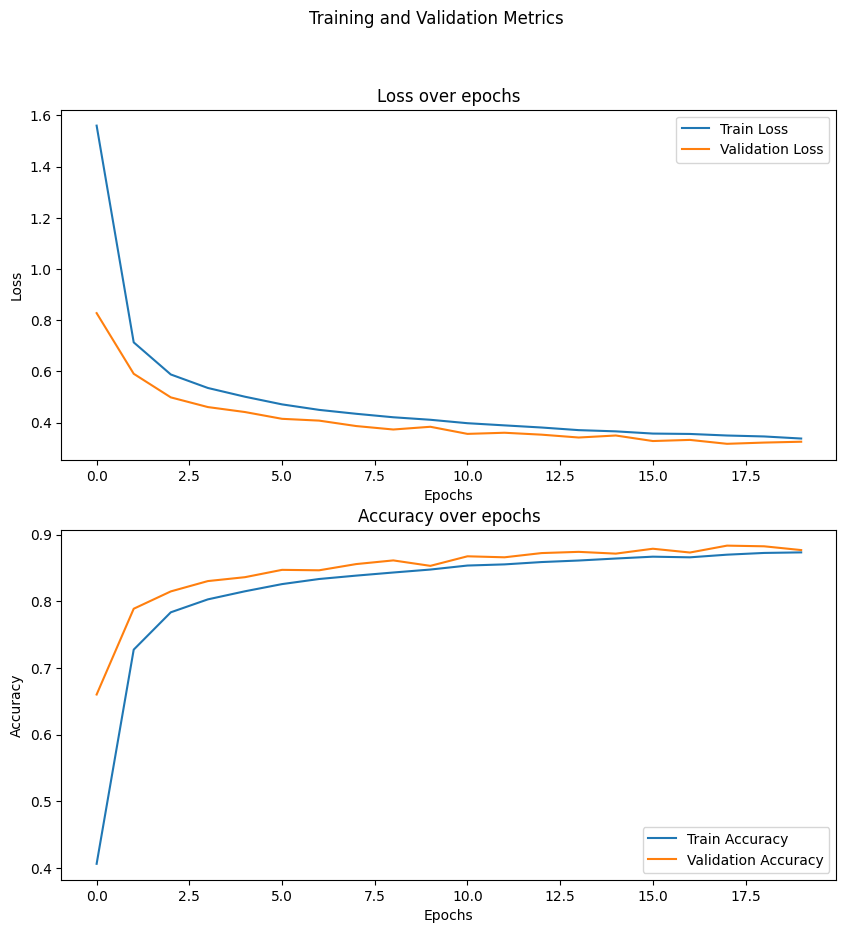

100%|██████████| 20/20 [00:01<00:00, 18.85it/s]

Test Loss: 0.3272
Test Accuracy: 0.8792


In [21]:
learned_postional_embedding = PatchEmbeddingLearnedPositionalEmbedding(EMBEDING_DIMENTION, PATCH_SIZE, NUM_PATCHES, DROPUT, IN_CHANNELS)
model_learned = training_loop(learned_postional_embedding, 'best_model_learned_embedding.pt')
test_model(model_learned, 'best_model_learned_embedding.pt')

  5%|▌         | 1/20 [00:19<06:02, 19.06s/it]

Epoch 1: New best model saved with val_loss: 0.9317
------------------------------
Train Loss EPOCH 1: 1.3644
Valid Loss EPOCH 1: 0.9317
Train Accuracy EPOCH 1: 0.5096
Valid Accuracy EPOCH 1: 0.6650
------------------------------


 10%|█         | 2/20 [00:37<05:36, 18.71s/it]

Epoch 2: New best model saved with val_loss: 0.7768
------------------------------
Train Loss EPOCH 2: 0.8591
Valid Loss EPOCH 2: 0.7768
Train Accuracy EPOCH 2: 0.6914
Valid Accuracy EPOCH 2: 0.7227
------------------------------


 15%|█▌        | 3/20 [00:54<05:06, 18.05s/it]

Epoch 3: New best model saved with val_loss: 0.7202
------------------------------
Train Loss EPOCH 3: 0.7570
Valid Loss EPOCH 3: 0.7202
Train Accuracy EPOCH 3: 0.7245
Valid Accuracy EPOCH 3: 0.7352
------------------------------


 20%|██        | 4/20 [01:11<04:41, 17.62s/it]

Epoch 4: New best model saved with val_loss: 0.6696
------------------------------
Train Loss EPOCH 4: 0.6960
Valid Loss EPOCH 4: 0.6696
Train Accuracy EPOCH 4: 0.7471
Valid Accuracy EPOCH 4: 0.7530
------------------------------


 25%|██▌       | 5/20 [01:29<04:27, 17.84s/it]

Epoch 5: New best model saved with val_loss: 0.6040
------------------------------
Train Loss EPOCH 5: 0.6581
Valid Loss EPOCH 5: 0.6040
Train Accuracy EPOCH 5: 0.7587
Valid Accuracy EPOCH 5: 0.7792
------------------------------


 30%|███       | 6/20 [01:47<04:08, 17.74s/it]

Epoch 6: New best model saved with val_loss: 0.5523
------------------------------
Train Loss EPOCH 6: 0.6280
Valid Loss EPOCH 6: 0.5523
Train Accuracy EPOCH 6: 0.7718
Valid Accuracy EPOCH 6: 0.8012
------------------------------


 35%|███▌      | 7/20 [02:04<03:46, 17.46s/it]

Epoch 7: New best model saved with val_loss: 0.5499
------------------------------
Train Loss EPOCH 7: 0.6007
Valid Loss EPOCH 7: 0.5499
Train Accuracy EPOCH 7: 0.7802
Valid Accuracy EPOCH 7: 0.8035
------------------------------


 40%|████      | 8/20 [02:21<03:27, 17.30s/it]

Epoch 8: New best model saved with val_loss: 0.5422
------------------------------
Train Loss EPOCH 8: 0.5825
Valid Loss EPOCH 8: 0.5422
Train Accuracy EPOCH 8: 0.7869
Valid Accuracy EPOCH 8: 0.8067
------------------------------


 45%|████▌     | 9/20 [02:38<03:09, 17.23s/it]

------------------------------
Train Loss EPOCH 9: 0.5590
Valid Loss EPOCH 9: 0.5571
Train Accuracy EPOCH 9: 0.7948
Valid Accuracy EPOCH 9: 0.7918
------------------------------


 50%|█████     | 10/20 [02:55<02:51, 17.18s/it]

Epoch 10: New best model saved with val_loss: 0.5140
------------------------------
Train Loss EPOCH 10: 0.5429
Valid Loss EPOCH 10: 0.5140
Train Accuracy EPOCH 10: 0.8013
Valid Accuracy EPOCH 10: 0.8158
------------------------------


 55%|█████▌    | 11/20 [03:12<02:33, 17.10s/it]

Epoch 11: New best model saved with val_loss: 0.5059
------------------------------
Train Loss EPOCH 11: 0.5285
Valid Loss EPOCH 11: 0.5059
Train Accuracy EPOCH 11: 0.8061
Valid Accuracy EPOCH 11: 0.8157
------------------------------


 60%|██████    | 12/20 [03:29<02:16, 17.00s/it]

Epoch 12: New best model saved with val_loss: 0.4865
------------------------------
Train Loss EPOCH 12: 0.5219
Valid Loss EPOCH 12: 0.4865
Train Accuracy EPOCH 12: 0.8089
Valid Accuracy EPOCH 12: 0.8230
------------------------------


 65%|██████▌   | 13/20 [03:46<01:59, 17.02s/it]

Epoch 13: New best model saved with val_loss: 0.4791
------------------------------
Train Loss EPOCH 13: 0.5202
Valid Loss EPOCH 13: 0.4791
Train Accuracy EPOCH 13: 0.8096
Valid Accuracy EPOCH 13: 0.8272
------------------------------


 70%|███████   | 14/20 [04:02<01:41, 16.91s/it]

Epoch 14: New best model saved with val_loss: 0.4706
------------------------------
Train Loss EPOCH 14: 0.5009
Valid Loss EPOCH 14: 0.4706
Train Accuracy EPOCH 14: 0.8176
Valid Accuracy EPOCH 14: 0.8213
------------------------------


 75%|███████▌  | 15/20 [04:19<01:24, 16.95s/it]

Epoch 15: New best model saved with val_loss: 0.4597
------------------------------
Train Loss EPOCH 15: 0.4935
Valid Loss EPOCH 15: 0.4597
Train Accuracy EPOCH 15: 0.8174
Valid Accuracy EPOCH 15: 0.8295
------------------------------


 80%|████████  | 16/20 [04:36<01:07, 16.91s/it]

Epoch 16: New best model saved with val_loss: 0.4473
------------------------------
Train Loss EPOCH 16: 0.4842
Valid Loss EPOCH 16: 0.4473
Train Accuracy EPOCH 16: 0.8207
Valid Accuracy EPOCH 16: 0.8337
------------------------------


 85%|████████▌ | 17/20 [04:53<00:50, 16.84s/it]

------------------------------
Train Loss EPOCH 17: 0.4713
Valid Loss EPOCH 17: 0.4516
Train Accuracy EPOCH 17: 0.8265
Valid Accuracy EPOCH 17: 0.8358
------------------------------


 90%|█████████ | 18/20 [05:10<00:33, 16.80s/it]

------------------------------
Train Loss EPOCH 18: 0.4620
Valid Loss EPOCH 18: 0.4479
Train Accuracy EPOCH 18: 0.8293
Valid Accuracy EPOCH 18: 0.8285
------------------------------


 95%|█████████▌| 19/20 [05:27<00:16, 16.84s/it]

------------------------------
Train Loss EPOCH 19: 0.4629
Valid Loss EPOCH 19: 0.4537
Train Accuracy EPOCH 19: 0.8291
Valid Accuracy EPOCH 19: 0.8300
------------------------------


100%|██████████| 20/20 [05:44<00:00, 17.21s/it]


------------------------------
Train Loss EPOCH 20: 0.4554
Valid Loss EPOCH 20: 0.4761
Train Accuracy EPOCH 20: 0.8312
Valid Accuracy EPOCH 20: 0.8225
------------------------------
Completed all epochs without early stopping.
Training Time: 344.30s


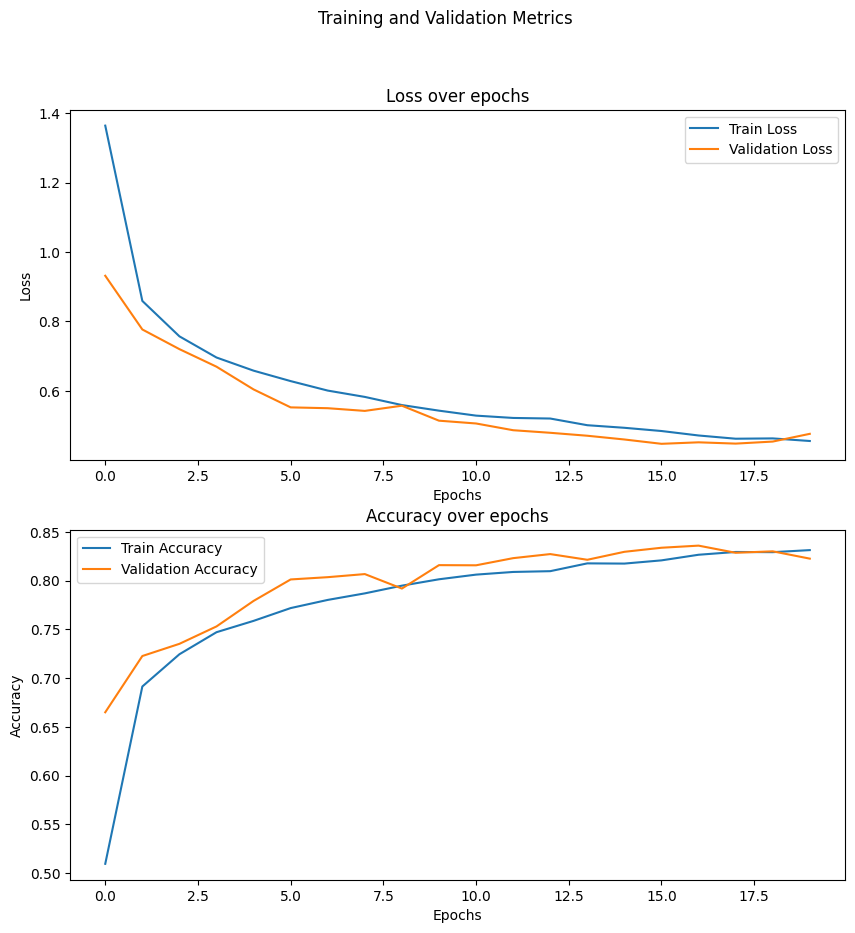

100%|██████████| 20/20 [00:01<00:00, 18.43it/s]


Test Loss: 0.4518
Test Accuracy: 0.8336


In [22]:
no_postional_embedding = PatchEmbeddingNoPositionalEmbedding(EMBEDING_DIMENTION, PATCH_SIZE, NUM_PATCHES, DROPUT, IN_CHANNELS)
model_no_embedding = training_loop(no_postional_embedding, 'best_model_no_embedding.pt')
test_model(model_no_embedding, 'best_model_no_embedding.pt')

  5%|▌         | 1/20 [00:17<05:31, 17.45s/it]

Epoch 1: New best model saved with val_loss: 0.8001
------------------------------
Train Loss EPOCH 1: 1.5261
Valid Loss EPOCH 1: 0.8001
Train Accuracy EPOCH 1: 0.4323
Valid Accuracy EPOCH 1: 0.7127
------------------------------


 10%|█         | 2/20 [00:34<05:09, 17.20s/it]

Epoch 2: New best model saved with val_loss: 0.6221
------------------------------
Train Loss EPOCH 2: 0.7361
Valid Loss EPOCH 2: 0.6221
Train Accuracy EPOCH 2: 0.7281
Valid Accuracy EPOCH 2: 0.7612
------------------------------


 15%|█▌        | 3/20 [00:51<04:48, 16.98s/it]

Epoch 3: New best model saved with val_loss: 0.5437
------------------------------
Train Loss EPOCH 3: 0.6246
Valid Loss EPOCH 3: 0.5437
Train Accuracy EPOCH 3: 0.7692
Valid Accuracy EPOCH 3: 0.7942
------------------------------


 20%|██        | 4/20 [01:08<04:30, 16.93s/it]

Epoch 4: New best model saved with val_loss: 0.4923
------------------------------
Train Loss EPOCH 4: 0.5713
Valid Loss EPOCH 4: 0.4923
Train Accuracy EPOCH 4: 0.7899
Valid Accuracy EPOCH 4: 0.8230
------------------------------


 25%|██▌       | 5/20 [01:25<04:15, 17.06s/it]

------------------------------
Train Loss EPOCH 5: 0.5295
Valid Loss EPOCH 5: 0.5143
Train Accuracy EPOCH 5: 0.8051
Valid Accuracy EPOCH 5: 0.8118
------------------------------


 30%|███       | 6/20 [01:42<03:57, 17.00s/it]

Epoch 6: New best model saved with val_loss: 0.4362
------------------------------
Train Loss EPOCH 6: 0.5050
Valid Loss EPOCH 6: 0.4362
Train Accuracy EPOCH 6: 0.8142
Valid Accuracy EPOCH 6: 0.8425
------------------------------


 35%|███▌      | 7/20 [01:59<03:41, 17.04s/it]

------------------------------
Train Loss EPOCH 7: 0.4834
Valid Loss EPOCH 7: 0.4518
Train Accuracy EPOCH 7: 0.8214
Valid Accuracy EPOCH 7: 0.8338
------------------------------


 40%|████      | 8/20 [02:16<03:24, 17.02s/it]

Epoch 8: New best model saved with val_loss: 0.4335
------------------------------
Train Loss EPOCH 8: 0.4727
Valid Loss EPOCH 8: 0.4335
Train Accuracy EPOCH 8: 0.8260
Valid Accuracy EPOCH 8: 0.8432
------------------------------


 45%|████▌     | 9/20 [02:33<03:07, 17.07s/it]

Epoch 9: New best model saved with val_loss: 0.4158
------------------------------
Train Loss EPOCH 9: 0.4594
Valid Loss EPOCH 9: 0.4158
Train Accuracy EPOCH 9: 0.8299
Valid Accuracy EPOCH 9: 0.8537
------------------------------


 50%|█████     | 10/20 [02:50<02:51, 17.11s/it]

------------------------------
Train Loss EPOCH 10: 0.4424
Valid Loss EPOCH 10: 0.4250
Train Accuracy EPOCH 10: 0.8361
Valid Accuracy EPOCH 10: 0.8425
------------------------------


 55%|█████▌    | 11/20 [03:08<02:34, 17.19s/it]

Epoch 11: New best model saved with val_loss: 0.4110
------------------------------
Train Loss EPOCH 11: 0.4291
Valid Loss EPOCH 11: 0.4110
Train Accuracy EPOCH 11: 0.8425
Valid Accuracy EPOCH 11: 0.8482
------------------------------


 60%|██████    | 12/20 [03:24<02:16, 17.06s/it]

Epoch 12: New best model saved with val_loss: 0.3817
------------------------------
Train Loss EPOCH 12: 0.4269
Valid Loss EPOCH 12: 0.3817
Train Accuracy EPOCH 12: 0.8420
Valid Accuracy EPOCH 12: 0.8530
------------------------------


 65%|██████▌   | 13/20 [03:42<01:59, 17.11s/it]

Epoch 13: New best model saved with val_loss: 0.3783
------------------------------
Train Loss EPOCH 13: 0.4142
Valid Loss EPOCH 13: 0.3783
Train Accuracy EPOCH 13: 0.8450
Valid Accuracy EPOCH 13: 0.8600
------------------------------


 70%|███████   | 14/20 [03:58<01:42, 17.01s/it]

------------------------------
Train Loss EPOCH 14: 0.4075
Valid Loss EPOCH 14: 0.3875
Train Accuracy EPOCH 14: 0.8464
Valid Accuracy EPOCH 14: 0.8562
------------------------------


 75%|███████▌  | 15/20 [04:15<01:25, 17.02s/it]

Epoch 15: New best model saved with val_loss: 0.3641
------------------------------
Train Loss EPOCH 15: 0.4029
Valid Loss EPOCH 15: 0.3641
Train Accuracy EPOCH 15: 0.8500
Valid Accuracy EPOCH 15: 0.8648
------------------------------


 80%|████████  | 16/20 [04:32<01:07, 16.97s/it]

------------------------------
Train Loss EPOCH 16: 0.3971
Valid Loss EPOCH 16: 0.3706
Train Accuracy EPOCH 16: 0.8521
Valid Accuracy EPOCH 16: 0.8625
------------------------------


 85%|████████▌ | 17/20 [04:49<00:50, 16.93s/it]

Epoch 17: New best model saved with val_loss: 0.3559
------------------------------
Train Loss EPOCH 17: 0.3936
Valid Loss EPOCH 17: 0.3559
Train Accuracy EPOCH 17: 0.8539
Valid Accuracy EPOCH 17: 0.8648
------------------------------


 90%|█████████ | 18/20 [05:06<00:33, 16.91s/it]

------------------------------
Train Loss EPOCH 18: 0.3881
Valid Loss EPOCH 18: 0.3570
Train Accuracy EPOCH 18: 0.8557
Valid Accuracy EPOCH 18: 0.8690
------------------------------


 95%|█████████▌| 19/20 [05:23<00:16, 16.94s/it]

Epoch 19: New best model saved with val_loss: 0.3539
------------------------------
Train Loss EPOCH 19: 0.3795
Valid Loss EPOCH 19: 0.3539
Train Accuracy EPOCH 19: 0.8575
Valid Accuracy EPOCH 19: 0.8647
------------------------------


100%|██████████| 20/20 [05:40<00:00, 17.02s/it]


------------------------------
Train Loss EPOCH 20: 0.3739
Valid Loss EPOCH 20: 0.3564
Train Accuracy EPOCH 20: 0.8605
Valid Accuracy EPOCH 20: 0.8648
------------------------------
Completed all epochs without early stopping.
Training Time: 340.39s


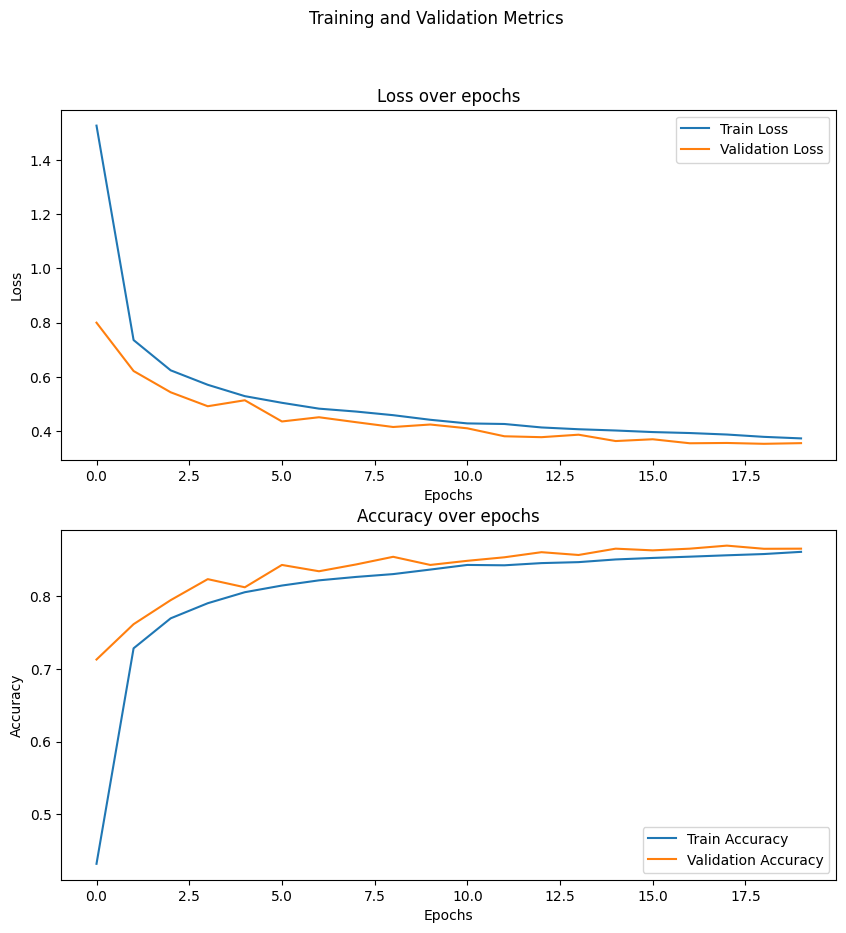

100%|██████████| 20/20 [00:01<00:00, 18.92it/s]

Test Loss: 0.3665
Test Accuracy: 0.8623


In [23]:
hilbert_embedding = PatchEmbeddingHilbertPositionalEmbedding(EMBEDING_DIMENTION, PATCH_SIZE, NUM_PATCHES, DROPUT, IN_CHANNELS, IMAGE_SIZE)
model_hilbert = training_loop(hilbert_embedding, 'hilbert_embedding.pt')
test_model(model_hilbert, 'hilbert_embedding.pt')